# Proyecto Semestral - Entrega final

Luciano Davico  
Gregory Schuit  

En el presente notebook se presenta el análisis de datos sobre terremotos y tsunamis, especificamente mediante la implementación de un Random Forest para poder discriminar entre terremotos que ocasionan tsunamis y los que no.

In [122]:
import pandas as pd
import numpy as np
from time import time, sleep
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing

In [39]:
# Leemos los datos de terremotos y filtramos las features.
quakes_df = pd.read_csv('Data/quakes.csv')
print(len(quakes_df))
quakes_df.columns

415677


Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')

In [40]:
quakes_df = quakes_df[['latitude', 'longitude', 'depth', 'mag', 'time']]
quakes_df.head()

,latitude,longitude,depth,mag,time
0,37.6457,20.8702,10.00,4.7,2018-10-27T18:33:12.420Z
1,65.2234,-151.6636,16.60,5.3,2018-10-27T16:57:27.956Z
2,-22.4704,-68.6516,113.79,4.7,2018-10-27T15:46:43.390Z
3,-56.0652,-27.4276,93.78,4.9,2018-10-27T15:00:46.800Z
4,37.3128,20.4930,10.00,4.6,2018-10-27T14:33:26.470Z


In [41]:
min(quakes_df['time'])

'1900-07-29T06:59:00.000Z'

In [42]:
# Leemos los dato de tsunamis y seleccionamos las features
tsunamis_df = pd.read_csv('Data/tsunamis.tsv', sep='\t', encoding='iso-8859-1')
tsunamis_df = tsunamis_df[tsunamis_df['YEAR'] >= 1900]
tsunamis_df = tsunamis_df[['PRIMARY_MAGNITUDE', 'LATITUDE', 'LONGITUDE', 'YEAR']]
print(len(tsunamis_df))
tsunamis_df.head()

773


,PRIMARY_MAGNITUDE,LATITUDE,LONGITUDE,YEAR
372,6.6,-4.0,152.0,1900
373,7.1,-5.0,148.0,1900
374,6.9,-4.0,140.0,1900
375,8.4,11.0,-66.0,1900
376,6.0,39.0,143.0,1901


Es posibe observar que existen 415677 terremotos y tan solo 1145 tsunamis. Este problema de desbalance se nivelará filtrando intervalos con muchos terremotos y pocos tsunamis, es decir, el rango de magnitudes bajas. A continuación observaremos los datos para determinar un punto de corte.

In [43]:
# Observamos distribuciones de la magnitud
plt = tsunamis_df['PRIMARY_MAGNITUDE'].hist(bins=40, figsize=(10, 3))

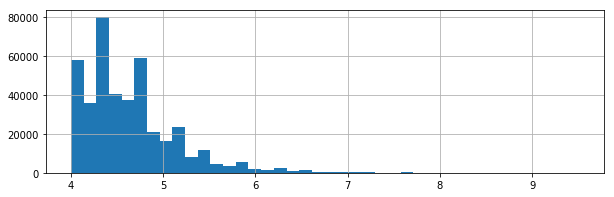

In [44]:
plt = quakes_df['mag'].hist(bins=40, figsize=(10, 3))

A partir de los histogramas, es posible apreciar que la gran mayoria de los terremotos bajo 6 grados aproximadamente, no genera tsunami alguno. Por esta razón es que lo consideraremos como el punto de corte.

In [45]:
corte = 6.3
print(len(tsunamis_df[tsunamis_df['PRIMARY_MAGNITUDE'] > corte]))
print(len(quakes_df[quakes_df['mag'] > corte]))

663
4930


In [46]:
tsunamis_df = tsunamis_df[tsunamis_df['PRIMARY_MAGNITUDE'] > corte]
quakes_df = quakes_df[quakes_df['mag'] > corte]

Ahora, procederemos a hacer el join de ambas tablas

In [47]:
# Creamos una nueva columna en el dataset de terremotos,
# que por defecto será la ausencia de tsunami.
quakes_df['tsunami'] = 0

t0, i, total = time(), 0, len(quakes_df)
for index, row in quakes_df.iterrows():  # Para cada terremoto, se busca la correspondencia
    lat = row['latitude']                # en la tabla tsunamis.
    lon = row['longitude']
    mag = row['mag']
    year = int(row['time'][:4])
    
    delta_pos = 2.5  # valores tuneados a mano para el margen de error.
    delta_mag = 0.3
    
    cond1 = abs(tsunamis_df['LATITUDE'] - lat) < delta_pos
    cond2 = abs(tsunamis_df['LONGITUDE'] - lon) < delta_pos
    cond3 = abs(tsunamis_df['PRIMARY_MAGNITUDE'] - mag) < delta_mag
    cond4 = tsunamis_df['YEAR'] == year
    
    # Si existe un elemento en la tabla de tsunamis con las features muy cercanas,
    # se le asocia al terremoto.
    if len(tsunamis_df.loc[cond1 & cond2 & cond3 & cond4]) >= 1:
        quakes_df.at[index, 'tsunami'] = 1
    else:
        quakes_df.at[index, 'tsunami'] = 0
    
    i += 1
    if i % 80 == 0:
        print('Seconds left: {:.2f}'.format((time() - t0)/i * (total - i)), end='\r')

print('Total time: {:.2f}'.format(time() - t0))
len(quakes_df[quakes_df['tsunami'] == 1]), len(tsunamis_df)

Total time: 25.9266


(671, 663)

In [48]:
quakes_df.head()

,latitude,longitude,depth,mag,time,tsunami
79,37.5055,20.5626,14.00,6.8,2018-10-25T22:54:51.830Z,1
147,49.3142,-129.6725,10.00,6.5,2018-10-22T06:22:48.810Z,0
148,49.3468,-129.2135,10.00,6.8,2018-10-22T06:16:28.160Z,0
149,49.2496,-129.4783,10.96,6.6,2018-10-22T05:39:40.330Z,0
335,-21.7260,169.4867,10.00,6.4,2018-10-16T01:03:43.090Z,0


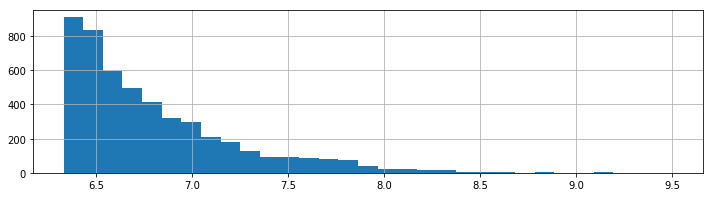

In [49]:
# Magnitudes de todos los terremotos
plt = quakes_df['mag'].hist(bins=31, figsize=(12,3))

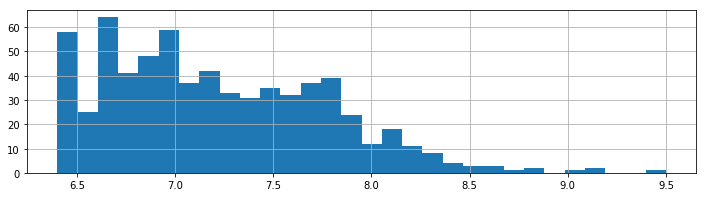

In [50]:
# Magnitudes de terremotos que provocaron tsunamis
plt = quakes_df[quakes_df['tsunami'] == 1]['mag'].hist(bins=30, figsize=(12,3))

# Visualization

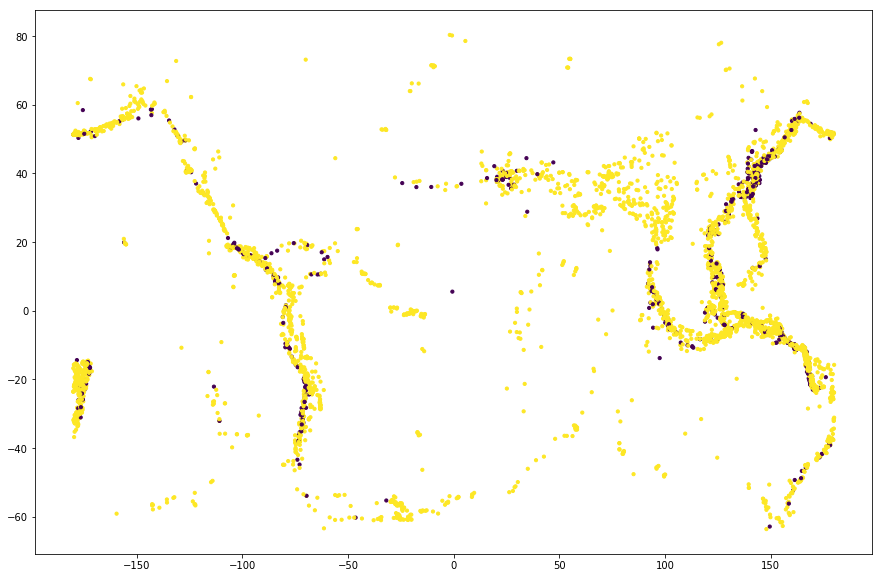

In [147]:
N = 100
r0 = 0.6
x = quakes_df['longitude']
y = quakes_df['latitude']

area = 10 # 0 to 10 point radii

plt.figure(figsize=(15,10))
plt.scatter(x, y, s=area, marker='o', c=1-quakes_df['tsunami'], alpha=1)
plt.show()

# Testing Models

In [89]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, \
                            classification_report

# Definimos un decorador para tomar el tiempo de las funciones
def timer(f_in):
    def f_out(*args, **kwargs):
        t0 = time()
        ret = f_in(*args, **kwargs)
        print("\nTotal time spent: {:.2f}s\n".format(time() - t0))
        return ret
    return f_out

In [76]:
# Dividimos matriz de features y vector de clase
quakes_features = quakes_df[['latitude', 'longitude', 'depth', 'mag']]
target = quakes_df['tsunami']

In [116]:
# RANDOM FOREST #
@timer
def fitRandomForest(X, y, seed=0):
    
    clf = RandomForestClassifier(n_estimators=75, max_depth=10, 
                                 class_weight='balanced' , random_state=seed)
    trained = clf.fit(X, y)
    
    return trained


# REGRESIÓN LOGÍSTICA #
@timer
def fitRegresionLogistica(X, y, seed=0):
    
    clf = LogisticRegression(class_weight='balanced', 
                             random_state=seed)  # Con este parámetro se ajustan los pesos según la frecuencia de la clase
    trained = clf.fit(X, y)
    
    return trained


# SUPPORT VECTOR MACHINE #
@timer
def fitSupportVectorMachine(X, y, C=1, seed=0):
    
    clf = SVC(C=C,  # Valor de la penalización 
              kernel='sigmoid', class_weight='balanced', 
              probability=True, random_state=seed)
    trained = clf.fit(X, y)
    
    return trained


# NEURAL NETWORK
@timer
def fitNeuralNetwork(X, y, seed=0):
    
    clf = MLPClassifier(solver='adam',
                        hidden_layer_sizes=(10000,),
                        random_state=seed)
    trained = clf.fit(X, y)
    
    return trained


In [112]:
# Predicción 
def prediction(X_test, trained):
    y_pred = trained.predict(X_test)
    return y_pred


# Partición estratificada

X_train, X_test, y_train, y_test = train_test_split(quakes_features, target, test_size=0.3,
                                                    random_state=1, stratify=target)

In [113]:
# RANDOM FOREST
display(HTML('<h3> Resultados de métricas evaluadas con Random Forest:\n</h3>'))

trained = fitRandomForest(X_train, y_train, seed=1)
y_pred = prediction(X_test, trained)

print(classification_report(y_test, y_pred, target_names=['no provoca tsunami', 'sí provoca tsunami']))
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')   ## accuracy
print('Matriz de Confusión:\n\n', confusion_matrix(y_test, y_pred), '\n')   ## Matriz de Confusion


Total time spent: 0.52s

                    precision    recall  f1-score   support

no provoca tsunami       0.93      0.93      0.93      1278
sí provoca tsunami       0.55      0.58      0.57       201

       avg / total       0.88      0.88      0.88      1479

Accuracy:  0.8796484110885734 

Matriz de Confusión:

 [[1184   94]
 [  84  117]] 



In [114]:
# REGRESION LOGÍSTICA
display(HTML('<h3> Resultados de métricas evaluadas con Regresion Logística\n</h3>'))

trained = fitRegresionLogistica(X_train, y_train, 1)
y_pred = prediction(X_test, trained)

print(classification_report(y_test, y_pred, target_names=['no provoca tsunami', 'sí provoca tsunami']))
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')   ## accuracy
print('Matriz de Confusión:\n\n', confusion_matrix(y_test, y_pred), '\n')   ## Matriz de Confusion


Total time spent: 0.03s

                    precision    recall  f1-score   support

no provoca tsunami       0.94      0.78      0.85      1278
sí provoca tsunami       0.33      0.70      0.45       201

       avg / total       0.86      0.77      0.80      1479

Accuracy:  0.7660581473968898 

Matriz de Confusión:

 [[993 285]
 [ 61 140]] 



In [121]:
# MAQUINA DE VECTORES DE SOPORTE
display(HTML('<h3> Resultados de métricas evaluadas con Support Vector Machine\n</h3>'))

trained = fitSupportVectorMachine(X_train, y_train, C=3, seed=1)
y_pred = prediction(X_test, trained)

print(classification_report(y_test, y_pred, target_names=['no provoca tsunami', 'sí provoca tsunami']))
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')   ## accuracy
print('Matriz de Confusión:\n\n', confusion_matrix(y_test, y_pred), '\n')   ## Matriz de Confusion


Total time spent: 1.66s

                    precision    recall  f1-score   support

no provoca tsunami       0.86      0.51      0.64      1278
sí provoca tsunami       0.13      0.46      0.20       201

       avg / total       0.76      0.50      0.58      1479

Accuracy:  0.49966193373901285 

Matriz de Confusión:

 [[647 631]
 [109  92]] 



SVC, es un clasificador que trata de encontrar un hiperplano divisor de los datos. Como podemos intuir de la naturaleza de los datos, estos no son separables por un hiperplano, por lo que es esperable que este clasificador tenga un mal rendimiento.

In [ ]:
# Provar con SVM con kernel.

In [110]:
# RED NEURONAL
display(HTML('<h3> Resultados de métricas evaluadas con Multilayer Perceptron\n</h3>'))

trained = fitNeuralNetwork(X_train, y_train)
y_pred = prediction(X_test, trained)

print(classification_report(y_test, y_pred, target_names=['no provoca tsunami', 'sí provoca tsunami']))
print('Accuracy: ', accuracy_score(y_test, y_pred), '\n')   ## accuracy
print('Matriz de Confusión:\n\n', confusion_matrix(y_test, y_pred), '\n')   ## Matriz de Confusion


Total time spent: 9.05s

                    precision    recall  f1-score   support

no provoca tsunami       0.86      1.00      0.93      1278
sí provoca tsunami       0.00      0.00      0.00       201

       avg / total       0.75      0.86      0.80      1479

Accuracy:  0.8640973630831643 

Matriz de Confusión:

 [[1278    0]
 [ 201    0]] 



/home/gregschuit/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


En el caso del modelo Random Forest queremos aumentar el Recall, para detectar casos en que aparezca la clase minoritaria. Es decir, queremos aumentar la cantidad de casos en que se predice un tsunami, dado que efectivamente ocurrirá.

Al incluir el parámetro class_weight='balanced' en la Regresión Logística, las clases adquieren un peso inversamente proporcional a la frecuencia de la clase. Como tenemos una base de datos desbalanceada, los valores 1 de la clase adquieren un peso mayor a los valores 0. Los resultados de esto indican que hay un aumento en el Recall, es decir, se han predicho correctamente un 82,23 % de los Tsunamis que han ocurrido. Esto es un avance, si se considera que con el modelo Random Forest se obtuvo un Recall cercano al 29,3 %. Sin embargo, la Precisión del modelo bajó notablemente a un 16,29 %, por lo que ahora se están prediciendo muchos más tsunamis de los que efectivamente ocurrieron.

In [55]:
# RANDOM SUBSAMPLING #

def RandomSubsampling(X_train, y_train, X_test, y_test, B, seed=None):
    
    lista_fscore = []
    lista_recall = []
    lista_precision = []
    lista_accuracy = []
    for i in range(B):
        trained = fitRandomForest(X_train, y_train, seed)    # Se evalúa modelo de Random Forest
        y_pred = prediction(X_test, trained)
        recall = recall_score(y_test, y_pred, average='binary')   ## recall
        precision = precision_score(y_test, y_pred, average='binary')   ## precision
        f_score = 2*(precision*recall)/(precision+recall)       ## F-score
        accuracy = accuracy_score(y_test, y_pred)   ## accuracy
        lista_fscore.append(f_score)
        lista_recall.append(recall)
        lista_precision.append(precision)
        lista_accuracy.append(accuracy)
    
    return lista_fscore, lista_recall, lista_precision, lista_accuracy
    

In [56]:
 #Se evalúa el modelo mediante RandomSubsampling

X_train, X_test, y_train, y_test = train_test_split(quakes_features, target, test_size=0.3, 
                                                    random_state=1, stratify=target)

listaFscore, listaRecall, listaPrecision, listaAccuracy = RandomSubsampling(X_train, 
                                                                            y_train, X_test, y_test, 20)

f_score = sum([i for i in listaFscore])/len(listaFscore)
recall = sum([i for i in listaRecall])/len(listaRecall)
precision = sum([i for i in listaPrecision])/len(listaPrecision)
accuracy = sum([i for i in listaAccuracy])/len(listaAccuracy)

f_score, recall, precision, accuracy

(0.5648482249474309,
 0.5883084577114427,
 0.5433184807426606,
 0.8768086544962813)


Para corregir el problema de clases desbalanceada, se utilizará Up-sample Minority Class. Este proceso consiste en aumentar la cantidad de observaciones con la clase minoritaria (en este caso, que ocurra un Tsunami i.e. '1'). Este aumento se da gracias a la duplicación de estos datos de forma aleatoria. Se duplicarán observaciones con reemplazo.

In [57]:
# UP-SAMPLE MINORITY CLASS #

from sklearn.utils import resample

quakes_df['tsunami'].value_counts()

0    4259
1     671
Name: tsunami, dtype: int64

Se ve que hay 808 tsunamis en la base de datos, dado que ha ocurrido un total de 23719 terremotos. Con el método que utilizaremos se definirá el set de train y a esta base de datos se la aplicará Up-Sample Minority Class, para luego predecir los datos del set de test.

In [58]:
# Se obtiene el set de train #

X_train, X_test, y_train, y_test = train_test_split(quakes_features, target, test_size=0.3, 
                                                    random_state=1, stratify=target)

train = X_train.join(y_train)

# Se separa la base de datos en dos partes; una solo con eventos de tsunami y otra sin tsunamis.

major = train[train.tsunami == 0] 
minor = train[train.tsunami == 1]

# Se duplican los datos de la clase minoritaria en la misma cantidad que en la clase mayoritaria

minor_sampled = resample(minor, replace=True, n_samples=len(major), random_state = 1)

# Se crea la nueva base de datos con la base de la clase mayoritaria y la base minoritaria sampleada

quakes_sampled = pd.concat([major, minor_sampled])
print(quakes_sampled['tsunami'].value_counts())

qk_sampled_X = quakes_sampled[['latitude', 'longitude', 'depth', 'mag']]
qk_sampled_y = quakes_sampled['tsunami']

1    2981
0    2981
Name: tsunami, dtype: int64


In [59]:
# Se evalúa el modelo Random Forest con la nueva base de datos de entrenamiento mediante RandomSubsampling 

listaFscore, listaRecall, listaPrecision, listaAccuracy = RandomSubsampling(qk_sampled_X, qk_sampled_y,
                                                                            X_test, y_test, 20, 1)

f_score = sum([i for i in listaFscore])/len(listaFscore)
recall = sum([i for i in listaRecall])/len(listaRecall)
precision = sum([i for i in listaPrecision])/len(listaPrecision)
accuracy = sum([i for i in listaAccuracy])/len(listaAccuracy)

print(f_score, recall, precision, accuracy)

0.5571725571725572 0.6666666666666664 0.4785714285714285 0.8559837728194726


Se ve claramente en los resultados que la predicción ha mejorado relativamente, al aplicar el modelo de Random Forest con Up-Sample Minority Class. El Recall ha aumentado de un 29,3 % a un ~ 81 %, sin embargo, la Precisión se desplomó desde un 71,7 % a un 25,48 %. En cuanto a la Accuracy y F-Score, estos disminuyeron entre 4 y 5 puntos aproximadamente. Para efectos prácticos, pese a que al ocupar Up Sample Minority Class empeoró la predicción, al ocupar este método se predice significativamente mejor los tsunamis que van a ocurrir. Esto es importante de considerar, ya que predecir un tsunami es muy importante para salvar vidas y lo anterior contribuye a poder determinar con rapidez medidas de contingencia. Desde otro punto de vista, dado que el modelo es poco preciso, también se predicen muchos tsunamis cuando estos no ocurren, lo que puede ser perjudicial desde el punto de vista de costos, ya que en la práctica se utilizarían muchos recursos de todo tipo en vano y habrían pérdidas.

In [60]:
quakes_df

,latitude,longitude,depth,mag,time,tsunami
79,37.505500,20.562600,14.00,6.8,2018-10-25T22:54:51.830Z,1
147,49.314200,-129.672500,10.00,6.5,2018-10-22T06:22:48.810Z,0
148,49.346800,-129.213500,10.00,6.8,2018-10-22T06:16:28.160Z,0
149,49.249600,-129.478300,10.96,6.6,2018-10-22T05:39:40.330Z,0
335,-21.726000,169.486700,10.00,6.4,2018-10-16T01:03:43.090Z,0
402,52.854900,153.242900,461.00,6.7,2018-10-13T11:10:22.400Z,0
467,49.290200,156.296800,20.00,6.5,2018-10-10T23:16:02.130Z,0
473,-5.707800,151.219700,45.05,7.0,2018-10-10T20:48:20.750Z,0
801,-18.346500,-178.078800,564.13,6.7,2018-09-30T10:52:24.240Z,0
910,-0.178100,119.840100,10.00,7.5,2018-09-28T10:02:43.480Z,0


In [61]:

# K-FOLD CROSS VALIDATION #

def CrossValidation(X, y, k):
    
    clf = RandomForestClassifier(n_estimators=75, max_depth=10, random_state=1) # Se evalúa modelo de Random Forest
    clf = clf.fit(X, y)
    return cross_val_score(clf, X, y, cv=k)

In [62]:
CrossValidation(quakes_features, target, 10)


array([0.8805668 , 0.89858012, 0.89249493, 0.90263692, 0.87423935,
       0.87018256, 0.90466531, 0.86409736, 0.90872211, 0.8902439 ])

In [66]:
def timer(f_in):
    def f_out(*args, **kwargs):
        t0 = time()
        ret = f_in(*args, **kwargs)
        print("\nTotal time spent: {:.2f}s".format(time() - t0))
        return ret
    return f_out

In [67]:
@timer
def contar(i, j):
    for x in range(i, j):
        print("{}...".format(x), end="\r")
        sleep(0.5)
    print("¡Salí!")
    return 

In [68]:
contar(1,10)

¡Salí!

Total time spent: 4.51s


In [69]:
timer(contar(1, 5))

¡Salí!

Total time spent: 2.00s


<function __main__.timer.<locals>.f_out(*args, **kwargs)>